In [1]:
import os
import pandas as pd
import numpy as np
import seaborn
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from scipy.spatial import distance_matrix

import warnings
warnings.filterwarnings('ignore')
from random import randint
from random import shuffle, random, sample, randint, randrange, uniform
import random
from scipy.spatial.distance import cdist
from haversine import haversine

C:\Users\antho\Anaconda3\lib\site-packages\cupy\_environment.py:206: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'
C:\Users\antho\Anaconda3\lib\site-packages\cupy\_environment.py:206: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'
C:\Users\antho\Anaconda3\lib\site-packages\cupy\_environment.py:206: UserWarning: CUDA path could not be detected. Set CUDA_PATH environment variable if CuPy fails to load.
  'CUDA path could not be detected.'


In [49]:
df_point=pd.read_excel("Candidatos_supermercados.xlsx")

In [50]:
df_point["ID2"]=df_point.ID.str.split(" ",expand=True)[1]

## Matriz de distancia Haversine 

In [51]:
from scipy.spatial.distance import cdist
from haversine import haversine

In [52]:
df_distance= pd.DataFrame(cdist(df_point[["Longitud","Latitud"]],df_point[["Longitud","Latitud"]],metric=haversine), index=df_point.ID2, columns=df_point.ID2)

In [53]:
import sys
import time
import numpy as np
import random
from copy import deepcopy
import matplotlib.pyplot as plt
from random import randrange

### Define el objeto Item en el problema de la mochila
Un objeto de clase Item almacena el valor del item y el peso del item 

### Estructura AG

Individio de AG cadena de 60bits, cada bit representa si una localización es seleccionada o no.

In [242]:
class Individual :

    def __init__(self, chromosome):  # el constructor recibe un cromosoma
        self.chromosome = chromosome[:]  
        self.fitness = -1  # -1 indica que el individuo no ha sido evaluado
  

    def crossover_onepoint(self, other):
        "Retorna dos nuevos individuos del cruzamiento de un punto entre individuos self y other "
        c = randrange(len(self.chromosome))
        ind1 = Individual(self.chromosome[:c] + other.chromosome[c:])
        ind2 = Individual(other.chromosome[:c] + self.chromosome[c:])
        return [ind1, ind2]   
    
    def crossover_uniform(self, other):
        chromosome1 = []
        chromosome2 = []
        "Retorna dos nuevos individuos del cruzamiento uniforme entre self y other "
        for i in range(len(self.chromosome)):
            if random.uniform(0, 1) < 0.5:
                chromosome1.append(self.chromosome[i])
                chromosome2.append(other.chromosome[i])
            else:
                chromosome1.append(other.chromosome[i])
                chromosome2.append(self.chromosome[i])
        ind1 = Individual(chromosome1)
        ind2 = Individual(chromosome2)
        return [ind1, ind2] 

    def mutation_flip(self):
        "Cambia el alelo de un gen escogido aleatoriamente."
        new_chromosome = deepcopy(self.chromosome)
        mutGene = random.randrange(0,len(new_chromosome))   # escoge un gen para mutar
        if new_chromosome[mutGene] == 0:
            new_chromosome[mutGene] = 1
        else:
            new_chromosome[mutGene] = 0
        return Individual(new_chromosome)
    
    def mutation_multiflip(self):
        new_chromosome = deepcopy(self.chromosome)
        index_list=list(range(0,len(new_chromosome))) #lista con indices del chromosomeinit
        random.shuffle(index_list)#orden aleatorio
        rdn_index=inde_list[0:int(len(index_list)/2)]#eligiendo el 50%
        
        for i in  range(0,len(new_chromosome)):
            if i in rdn_index:
                if new_chromosome[i] == 0:
                    new_chromosome[i] = 1
                else:
                    new_chromosome[i] = 0

        
        return Individual(new_chromosome)


### Funcion para obtener el fitness de un cromosoma

In [163]:
def get_fitness(chromosome, max_points):
    """Representa la suma de distancias entre todos los posibles pares de localizaciones escogidas en el individuo (45 pares distintos) (n*(n-1))/2 más la suma de las 
poblaciones alrededor de cada supermercado escogido"""
    fitness = 0 # initialize fitness to 0
    sum_locations = 0
    
    indexs = [i+1 for i, x in enumerate(chromosome) if x == 1] #Recupera todos los indexs con valor 1
    indexs=list(map(str,indexs))#Parse int para cruzarlo con la matriz de distancia
    fitness=df_distance.loc[indexs][indexs].values.sum()/2 *1000 # suma de todas las distancias en metros
    fitness=fitness+df_point[df_point["ID2"].isin(indexs)].iloc[:,4].sum()
            
    if len(indexs)>max_points:
        return 0.001
        #return fitness - 800000*(len(indexs)-max_points)
    return fitness

### Funcion para evaluar una población de individuos 

In [132]:
def evaluate_population(population, max_points):
    """ Evalua una poblacion de individuos con la funcion get_fitness """
    popsize = len(population)
    for i in range(popsize):
        if population[i].fitness == -1:    # evalua solo si el individuo no esta evaluado
            population[i].fitness = get_fitness(population[i].chromosome, max_points)

### Funcion para inicializar aleatoriamente una población de individuos

In [179]:
def init_population(popsize, chromosome_size, zeroes=False):
    """Inicializa una poblacion de popsize individuos, cada cromosoma de individuo de tamaño chromosome_size.
       Si zeroes==False La inicializacion es aleatoria (por defecto), si zeroes=True los cromosomas son vectores de ceros"""
    population = []
    for i in range(popsize):
        new_chromosome=[0]*chromosome_size
        lista=random.sample(range(0,chromosome_size ), 20)
        for u in range(0,chromosome_size):
            if u in lista:
                new_chromosome[u]=1
    
   
 
        population.append( Individual(new_chromosome) )
    return population

### Operadores de seleccion de padres

#### Seleccion por Ruleta

In [168]:
def select_parents_roulette(population):
    popsize = len(population)
    
    # Escoje el primer padre
    sumfitness = sum([indiv.fitness for indiv in population])  # suma total del fitness de la poblacion
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent1 = i
            break
    
    # Escoje el segundo padre, desconsiderando el primer padre
    sumfitness = sumfitness - population[iParent1].fitness # retira el fitness del padre ya escogido
    pickfitness = random.uniform(0, sumfitness)   # escoge un numero aleatorio entre 0 y sumfitness
    cumfitness = 0     # fitness acumulado
    for i in range(popsize):
        if i == iParent1: continue   # si es el primer padre 
        cumfitness += population[i].fitness
        if cumfitness > pickfitness: 
            iParent2 = i
            break        
    return (population[iParent1], population[iParent2])

#### Seleccion por Torneo

In [169]:
def select_parents_tournament(population, tournament_size):
    # Escoje el primer padre
    list_indiv=[]
    x1 = np.random.permutation(len(population) )
    y1= x1[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y1[i]].fitness)
    
    iParent1=np.argmax(list_indiv)
    
    # Escoje el segundo padre, desconsiderando el primer padre   
    x2 = np.delete(x1, iParent1)
    x2 = np.random.permutation(x2)
    list_indiv=[]
    y2= x2[0:tournament_size]
    for i in range(tournament_size):
        list_indiv.append(population[y2[i]].fitness)
    iParent2=np.argmax(list_indiv)
    
    return (population[x1[iParent1]],population[x2[iParent2]])

### Operadores de Seleccion de sobrevivientes


#### Función de selección de la poblacion para la sgte generación por ranking
Selecciona la población siguiente ranqueando los individuos de la poblacion actual (population) y la poblacion descendencia (offspring_population) y escogiendo los mejores numsurvivors  individuos 

In [170]:
def select_survivors_ranking(population, offspring_population, numsurvivors):
    next_population = []
    population.extend(offspring_population) # une las dos poblaciones
    isurvivors = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:numsurvivors]
    for i in range(numsurvivors):
        next_population.append(population[isurvivors[i]])
    return next_population

### Algoritmo Genetico para encontrar soluciones al problema de la mochila
Recibe una poblacion inicial, lista de items, maximo peso de la mochila (max_weight), numero de generaciones (ngen), taza de mutación (pmut), operador de cruzamiento (crossover), operador de mutacion (mutation), metodo de seleccion de padres (selection_parents_method), metodo de seleccion de sobrevivientes (selection_survivors_method) 

In [171]:
def genetic_algorithm(population, max_points, ngen=100, pmut=0.1, 
                      crossover="onepoint", mutation="flip", 
                      selection_parents_method="roulette", 
                      selection_survivors_method="ranking"):
    """
        max_points: número maximo de locaciones
        ngen:       maximo numero de generaciones 
        pmut:       tasa de mutacion
        crossover:  operador de cruzamiento
        mutation:   operador de mutacion
        selection_parents_method: método de selección de padres para cruzamiento
        selection_survivors_method: método de selección de sobrevivientes 
    """
    
    popsize = len(population)
    evaluate_population(population, max_points)  # evalua la poblacion inicial
    ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]  # mejor individuo
    bestfitness = [population[ibest[0]].fitness]  # fitness del mejor individuo
    print("Poblacion inicial, best_fitness = {}".format(population[ibest[0]].fitness))
    
    for g in range(ngen):   # Por cada generacion

        ## Selecciona parejas de individuos (mating_pool) para cruzamiento con el metodo de la ruleta
        mating_pool = []
        for i in range(int(popsize/2)):
            if selection_parents_method == "roulette":
                mating_pool.append(select_parents_roulette(population))
            elif selection_parents_method == "tournament":
                mating_pool.append(select_parents_tournament(population, 3))
            else:
                raise NotImplementedError
        ## Crea la poblacion descendencia cruzando las parejas del mating pool 
        offspring_population = []
        for i in range(len(mating_pool)): 
            if crossover == "onepoint":
                offspring_population.extend( mating_pool[i][0].crossover_onepoint(mating_pool[i][1]) ) # cruzamiento 1 punto
            elif crossover == "uniform":
                offspring_population.extend( mating_pool[i][0].crossover_uniform(mating_pool[i][1]) ) # cruzamiento uniforme
            else:
                raise NotImplementedError

        ## Aplica el operador de mutacion con probabilidad pmut en cada hijo generado
        for i in range(len(offspring_population)):
            if random.uniform(0, 1) < pmut: 
                if mutation == "flip":
                    offspring_population[i] = offspring_population[i].mutation_flip() # cambia el alelo de un gen
                elif mutation == "multiflip":
                    offspring_population[i] = offspring_population[i].mutation_multiflip() # cambia el alelo de un gen
                elif mutation == "inversion":
                    offspring_population[i] = offspring_population[i].mutation_inversion() # invierte todos los genes entre 2 puntos al azar
                else:
                    raise NotImplementedError   
        
        ## Evalua la poblacion descendencia creada
        evaluate_population(offspring_population, max_points)   # evalua la poblacion descendencia
        
        ## Selecciona individuos para la sgte. generación 
        if selection_survivors_method == "ranking":
            population = select_survivors_ranking(population, offspring_population, popsize) #metodo de ranking
        else:
            raise NotImplementedError
            
        ## Almacena la historia del fitness del mejor individuo
        ibest = sorted(range(len(population)), key=lambda i: population[i].fitness, reverse=True)[:1]
        bestfitness.append(population[ibest[0]].fitness)
        
        #if (g % 200 == 0):  # muestra resultados cada 10 generaciones
         #   print("generacion {}, (Mejor fitness = {})".format(g, population[ibest[0]].fitness))
        
    print("Mejor individuo en la ultima generacion = {} (fitness = {})".format(population[ibest[0]].chromosome, population[ibest[0]].fitness))
    return population[ibest[0]], bestfitness  # devuelve el mejor individuo y la lista de mejores fitness x gen

 ## Probando el Algoritmo genetico

<b> Ejecuta el algoritmo genetico </b>

Poblacion inicial, best_fitness = 0.001
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] (fitness = 631587.0297308282)


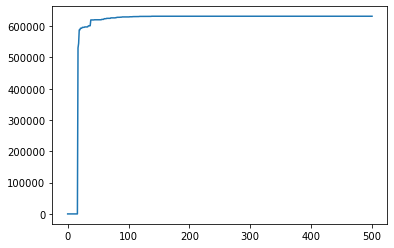

In [205]:
## Hiperparametros del algoritmo genetico
POPSIZE =100      # numero de individuos
GENERATIONS = 500   # numero de generaciones
PMUT = 0.3       # taza de mutacion

## Inicializa una poblacion inicial de forma aleatoria
population = init_population(POPSIZE, NUM_ITEMS)
pop2=population
# Evolue la poblacion con el algoritmo genetico (cruzamiento 'onepoint', )
best_ind, bestfitness = genetic_algorithm(population=population ,max_points= 10 , ngen=GENERATIONS, 
                                          pmut=PMUT,           crossover="uniform", mutation="flip",selection_parents_method = 'roulette',
                                          selection_survivors_method = 'ranking')
#genetic_algorithm()
# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()


Poblacion inicial, best_fitness = 0.001
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] (fitness = 631587.0297308282)


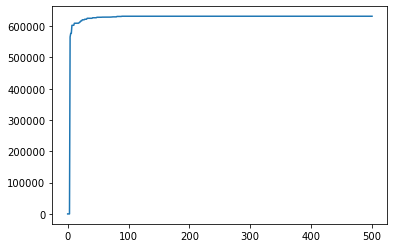

In [199]:
best_ind, bestfitness = genetic_algorithm(population=population ,max_points= 10 , ngen=GENERATIONS, 
                                          pmut=0.7,           crossover="uniform", mutation="flip",selection_parents_method = 'roulette',
                                          selection_survivors_method = 'ranking')
#genetic_algorithm()
# muestra la evolucion del mejor fitness
plt.plot(bestfitness)
plt.show()

In [236]:
def run_algo (pop,gene,pmut,cross,muta,parent,suvivor,max_points,n_corridas):
    import gc
    
    random.seed(2020) 
    bf_list=[]
    bi_list=[]
    fit_list=[]
    POPSIZE = pop       # numero de individuos
    GENERATIONS = gene   # numero de generaciones
    PMUT = pmut       # taza de mutacion
    population = init_population(POPSIZE, NUM_ITEMS)

    for i in range(1,n_corridas+1): 
        gc.collect()
        POPSIZE = pop       # numero de individuos
        GENERATIONS = gene   # numero de generaciones
        PMUT = pmut       # taza de mutacion
        population = init_population(POPSIZE, NUM_ITEMS)
        ## Inicializa una poblacion inicial de forma aleatoria
       # population = init_population(POPSIZE, NUM_ITEMS)
        # Evolue la poblacion con el algoritmo genetico (cruzamiento 'onepoint', )
        best_ind, bestfitness = genetic_algorithm(population, max_points, GENERATIONS, PMUT, 
                                                  crossover=cross, mutation=muta, 
                                                  selection_parents_method = parent, 
                                                  selection_survivors_method = suvivor)
        indexs = [i+1 for i, x in enumerate(best_ind.chromosome) if x == 1] #Recupera todos los indexs con valor 1
        indexs=list(map(str,indexs))#Parse int para cruzarlo con la matriz de distancia
        fitness1=df_distance.loc[indexs][indexs].values.sum()/2 *1000 # suma de todas las distancias en metros
        fitness2=df_point[df_point["ID2"].isin(indexs)].iloc[:,4].sum()
        fitness3=fitness1+fitness2
        bf_list.append(bestfitness)
        bi_list.append(best_ind)
        fit_list.append([fitness1,fitness2,fitness3])
    FIT_ME=np.mean([max(x) for x in bf_list ])
    CONVER=[]
    for a in bf_list:

        b=max(a)
        CONVER.append(a.index(b))
    CONVER= np.mean(CONVER)
    return FIT_ME,CONVER,bf_list,bi_list,pd.DataFrame(c, columns=["FIT_DISTANCE","FIT_POPULATION","FIT_TOTAL"])

In [237]:
FIT_OP_R,CON_OP_R,a,b,c=run_algo(100,500,0.3,"uniform","flip","roulette","ranking",10,10)

Poblacion inicial, best_fitness = 0.001
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] (fitness = 630551.6726289608)
Poblacion inicial, best_fitness = 0.001
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0] (fitness = 627068.3641190969)
Poblacion inicial, best_fitness = 0.001
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1] (fitness = 630509.2759242074)
Poblacion inicial, best_fitness = 0.001
Mejor individuo en la ultima generacion = [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,

In [238]:
c


,FIT_DISTANCE,FIT_POPULATION,FIT_TOTAL
0,500810.017899,128600,629410.017899
1,509514.830875,118800,628314.830875
2,499533.092912,129200,628733.092912
3,477636.049024,134150,611786.049024
4,508666.370245,120550,629216.370245
5,501427.746866,129700,631127.746866
6,501183.599999,125300,626483.599999
7,500744.730993,125450,626194.730993
8,510222.883566,120000,630222.883566
9,507875.230402,119100,626975.230402
